# 02 - Exploratory Data Analysis

In this notebook we will explore the data. Our goal is to predict whether or not the price of a flight will drop in the future to assist travelers in purchasing airline tickets. In this exploration of the data the plan is to try to understand the trends that flight prices follow over time and to discover the features that influence them.

1. Load data
2. Feature overview
3. Missing values
4. Feature Analysis
5. Price Over Time
6. Conclusions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
from datetime import datetime

In [2]:
sns.set_context('notebook')
sns.set_palette('deep')
import warnings
warnings.filterwarnings('ignore')

### Load data

In [3]:
flights = pd.read_csv('../data/interim/flights_interim.csv')
flights = flights.sample(2000000)
flights.shape

(2000000, 22)

In [4]:
flights.head()

,collectionDate,dDate,dTime,aDate,aTime,dTimeUTC,aTimeUTC,flyFrom,flyTo,airlines,...,distance,route,price,seats,cityFrom,cityCodeFrom,cityTo,cityCodeTo,countryFrom,countryTo
2094685,2021-03-24,2021-05-05,22:50,2021-05-06,15:45,2021-05-05 20:50:00,2021-05-06 19:45:00,MAD,JFK,"LY, LX",...,5767.20,MAD->TLV->VCE->ZRH->JFK,1036,NaN,Madrid,MAD,New York,NYC,Spain,United States
2780436,2021-04-08,2021-06-06,07:00,2021-06-06,08:20,2021-06-06 05:00:00,2021-06-06 07:20:00,BCN,LGW,IB,...,1110.28,BCN->LGW,151,1.0,Barcelona,BCN,London,LON,Spain,United Kingdom
2133352,2021-03-25,2021-05-24,17:50,2021-05-24,21:20,2021-05-24 15:50:00,2021-05-24 20:20:00,MAD,LHR,AF,...,1245.76,MAD->CDG->LHR,360,8.0,Madrid,MAD,London,LON,Spain,United Kingdom
446860,2021-02-09,2021-03-10,20:35,2021-03-11,08:55,2021-03-10 19:35:00,2021-03-11 08:55:00,BCN,LGW,UX,...,1110.28,BCN -> LGW,71,NaN,Barcelona,BCN,London,LON,Spain,United Kingdom
30235,2021-01-31,2021-04-29,01:35,2021-04-29,15:05,2021-04-28 23:35:00,2021-04-29 20:05:00,MAD,MEX,"AM, UX",...,9075.77,MAD -> MEX,1363,7.0,Madrid,MAD,Mexico City,MEX,Spain,Mexico


In [5]:
# Data transformations needed for some visualization:
flights['orig-dest'] = flights['flyFrom'] +'-'+ flights['flyTo']
flights['airline'] = flights['airlines'].apply(lambda x: x.split(',')[0])
flights['flight_no'] = flights['airline']+''+flights['flight_no'].astype(str)

### Features Overview

In [16]:
flights.columns

Index(['collectionDate', 'dDate', 'dTime', 'aDate', 'aTime', 'dTimeUTC',
       'aTimeUTC', 'flyFrom', 'flyTo', 'airlines', 'flight_no', 'fly_duration',
       'distance', 'route', 'price', 'seats', 'cityFrom', 'cityCodeFrom',
       'cityTo', 'cityCodeTo', 'countryFrom', 'countryTo', 'orig-dest',
       'airline', 'log_price'],
      dtype='object')

Features:
* **price**: airline ticket fare
* **collectionDate**: date flight data was taken
* **dDate**: departure day
* **dTime**: departure time
* **aDate**: arrival day
* **aTime**: arrival time
* **dTimeUTC**, **aTimeUTC**: departure and arrival time in UTC timezone
* **flyFrom**: origin airport IATA code
* **flyTo**: destination airport IATA code
* **airline**: self-explanatory
* **flight_no**: identification plain number
* **fly_duration**, **distance**: self-explanatory
* **route**: airports through the flight passes
* **seats**: availability
* **cityFrom**, **cityCodeFrom**, **cityTo**, **cityCodeTo**: different id's for the origin and destination cities
* **countryFrom**, **countryTo**: origin and dest countries

**Numerical**: distance, fly_duration, seats, price
\
**Categorical**: flyFrom, flyTo, airlines, route

Descriptive summary of the numerical features

In [7]:
flights[['distance', 'fly_duration', 'seats','price']].describe()

,distance,fly_duration,seats,price
count,2.000000e+06,2.000000e+06,1.572295e+06,2.000000e+06
mean,3.963220e+03,2.093316e+01,2.659506e+00,3.344228e+02
std,3.559816e+03,1.280448e+01,2.288498e+00,4.293548e+02
min,2.021800e+02,7.500000e-01,1.000000e+00,1.200000e+01
25%,1.110280e+03,1.216667e+01,1.000000e+00,1.060000e+02
50%,1.774110e+03,2.025000e+01,1.000000e+00,2.380000e+02
75%,5.767200e+03,2.773333e+01,3.000000e+00,3.930000e+02
max,1.009794e+04,6.000000e+01,8.000000e+00,7.543700e+04


### Missing Values

In [8]:
flights.isna().sum()

collectionDate         0
dDate                  0
dTime                  0
aDate                  0
aTime                  0
dTimeUTC               0
aTimeUTC               0
flyFrom                0
flyTo                  0
airlines               0
flight_no              0
fly_duration           0
distance               0
route                  0
price                  0
seats             427705
cityFrom               0
cityCodeFrom           0
cityTo                 0
cityCodeTo             0
countryFrom            0
countryTo              0
orig-dest              0
airline                0
dtype: int64

* 'seats' column has many missing values. Probably we will have to drop it.

## Feature Analysis

### Price

Price is one of the key features for our purpose. Let's start by looking at how it is distributed.

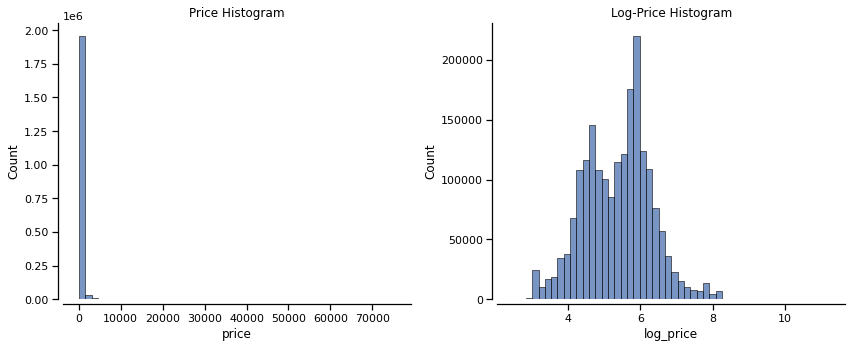

In [9]:
f, axes = plt.subplots(1, 2, figsize=(12,5))

# plot price hist
sns.histplot(x='price', data=flights, kde=False, bins=50, ax=axes[0]);
axes[0].set_title('Price Histogram')

# plot log transform price hist
flights['log_price'] = np.log(flights['price'])
sns.histplot(x='log_price', data=flights, kde=False, bins=50, ax=axes[1]);
axes[1].set_title('Log-Price Histogram')

sns.despine(offset=5)
plt.tight_layout()

* 'price' follows a exponential distribution and has many high values that skew to the right its distribution. 
* We have also plotted the price log-transformed.
* As we can see, 'log_price' aproximate a bit better to a normal distribution.

Let's see how price distribution changes according to the route:

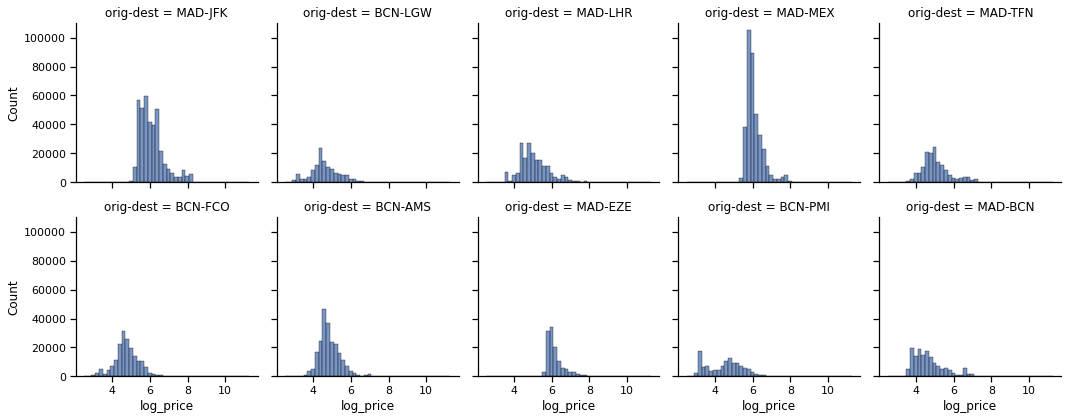

In [10]:
# Price distribution per route
sns.displot(
    flights, x="log_price", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=0.2, height=3
);
plt.tight_layout()

* As we can expect, some routes are more placed to the left (cheaper routes) and other to the right (more expensive routes).
* It seems that long-distance routes as 'MAD-MEX' (Madrid-Mexico) has narrower distribution than short-distance ones. 

And how does the price vary according to the route? Let's have a look

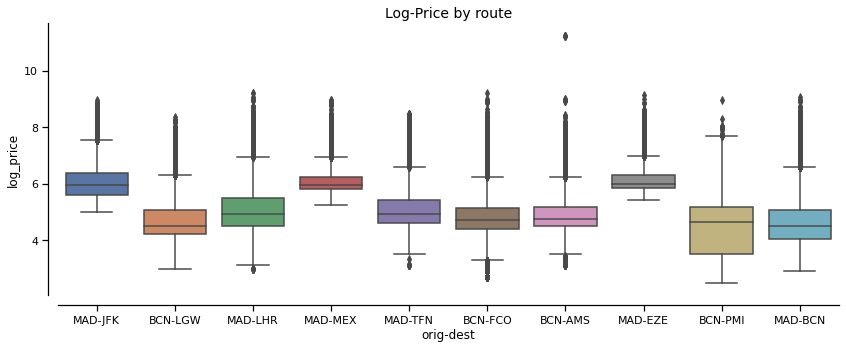

In [21]:
plt.figure(figsize=(14, 5))
sns.boxplot(x='orig-dest', y='log_price', data=flights);
sns.despine(offset=10)
plt.title('Log-Price by route', fontsize=14);

* As expected, longest routes have more expensive fares
* Many outliers

### CollectionDate

This date feature represents the day that data was collected. 
\
We can use this variable to compute a new 'Days until departure' numerical variable using this column and departure date colunm.

In [22]:
flights['collectionDate'].head()

2094685    2021-03-24
2780436    2021-04-08
2133352    2021-03-25
446860     2021-02-09
30235      2021-01-31
Name: collectionDate, dtype: object

In [26]:
flights['collectionDate'].nunique(), flights['collectionDate'].min(), flights['collectionDate'].max()

(76, '2021-01-31', '2021-04-19')

* We have 76 days of data collected
* From Jan 31 to April 19

### FlyFrom, FlyTo

We have collected flights from 10 routes:

In [20]:
routes = flights['flyFrom'] +'-'+ flights['flyTo']

In [21]:
routes.unique()

array(['MAD-BCN', 'BCN-FCO', 'MAD-TFN', 'BCN-PMI', 'MAD-LHR', 'MAD-JFK',
       'MAD-EZE', 'MAD-MEX', 'BCN-LGW', 'BCN-AMS'], dtype=object)

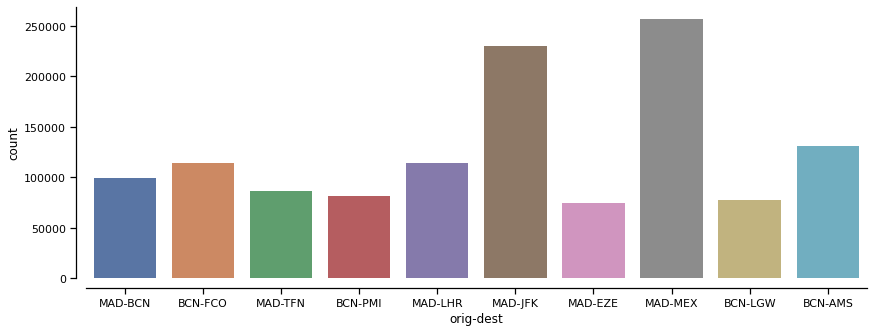

In [22]:
plt.figure(figsize=(14,5))
sns.countplot(x='orig-dest', data=flights)
sns.despine(offset=10);
plt.xticks(rotation=0);

* MAD-JFK (Madrid-New York) and MAD-MEX (Madrid-Mexico City) are the busiest routes. The rest of them have a similar traffic.

### Airlines

In [29]:
flights[['airlines', 'route']].head()

,airlines,route
2094685,"LY, LX",MAD->TLV->VCE->ZRH->JFK
2780436,IB,BCN->LGW
2133352,AF,MAD->CDG->LHR
446860,UX,BCN -> LGW
30235,"AM, UX",MAD -> MEX


* Airlines column show the carrier that manage a given flight. Hopping flights have more than one airline if there are diferent airlines in the itinerary.

In [26]:
flights['airline'].nunique()

131

There are 131 airlines in our dataset. Let's plot the top 40 busiest airline.

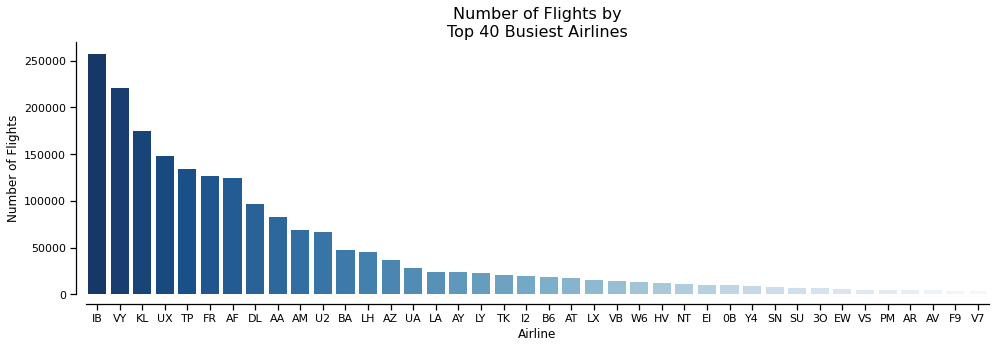

In [30]:
airlines_counts = flights.groupby('airline')['airline'].count()
busiest_airlines = airlines_counts.sort_values(ascending=False).head(40)

# plot
plt.figure(figsize=(14,5))
sns.barplot(x=busiest_airlines.index, y=busiest_airlines, palette='Blues_r')
plt.title('Number of Flights by\nTop 40 Busiest Airlines', fontsize=16)
plt.xlabel('Airline');
plt.ylabel('Number of Flights')
sns.despine(offset=10)
plt.tight_layout()

* Iberia (IB) is the airline with more flights in our dataset. Follow by Vueling (VY), KLM (KL), Air Europa (UX) and TAP Air Portugal (TP)

In [43]:
n_airlines = flights.groupby('orig-dest')['airline'].nunique().sort_values(ascending=False).reset_index()
n_airlines

,orig-dest,airline
0,MAD-MEX,100
1,MAD-JFK,96
2,MAD-LHR,86
3,MAD-BCN,84
4,BCN-FCO,77
5,BCN-LGW,74
6,BCN-AMS,72
7,MAD-EZE,68
8,BCN-PMI,63
9,MAD-TFN,62


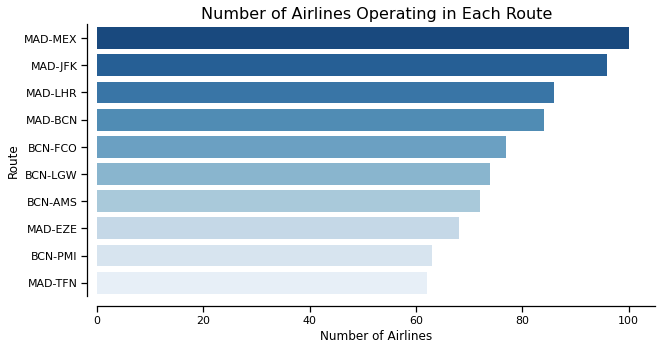

In [44]:
plt.figure(figsize=(10,5))
sns.barplot(x='airline', y='orig-dest', data=n_airlines, palette='Blues_r');
plt.title('Number of Airlines Operating in Each Route', fontsize=16)
plt.xlabel('Number of Airlines');
plt.ylabel('Route')
sns.despine(offset=10)

* MAD-MEX and MAD-JFK are the routes with the largest number of different airlines operating on them.
* In general, more airlines operate on international routes.

### Flight_no

In [30]:
pf['flight_no'].head()

0    UX7703
1    VY1003
2    IB1946
3    UX6097
4    UX6067
Name: flight_no, dtype: object

* It seeams that 'flight_no' identifies a unique plain. 

In [48]:
flights.groupby('flight_no')['orig-dest'].nunique().sort_values(ascending=False).head(5)

flight_no
VY3920    10
VY3916    10
UX3920     9
TP1423     9
IB3920     9
Name: orig-dest, dtype: int64

* There 'flight_no' values for more than one route. This means plains not always operates in the same itinerary.
* Probably we will drop this feature.

### Fly_duration

This feature represents the duration of the flight in hours.

In [33]:
flights['fly_duration'].head()

0     1.416667
1     1.250000
2     1.333333
3    13.583333
4    18.000000
Name: fly_duration, dtype: float64

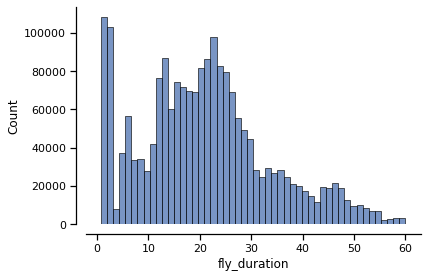

In [50]:
sns.histplot(flights['fly_duration'], bins=50);
sns.despine(offset=10)

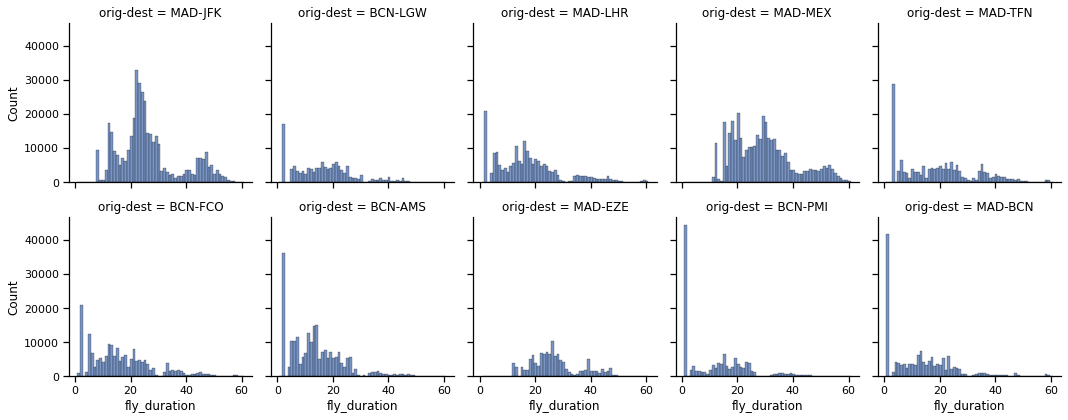

In [52]:
# fly_duration distribution for route
sns.displot(
    flights, x="fly_duration", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3
);
plt.tight_layout()

* It seems that there are variability in the fly_duration variable even in flights on the same route.
* We can notice that in some routes a considerable number of flights concentreates in some point on the left side. These are probable direct flights.

In [54]:
# Direct flights
flights['hops'] = flights['route'].apply(lambda x: len(x.split('->')) - 2)
flights['direct'] = flights['hops'] == 0

In [55]:
# There are observations with wrong column due an error during collection. We'll drop them.

split_date = datetime.strptime('2021-02-24', '%Y-%m-%d')
broken = pd.to_datetime(flights['collectionDate']) < split_date

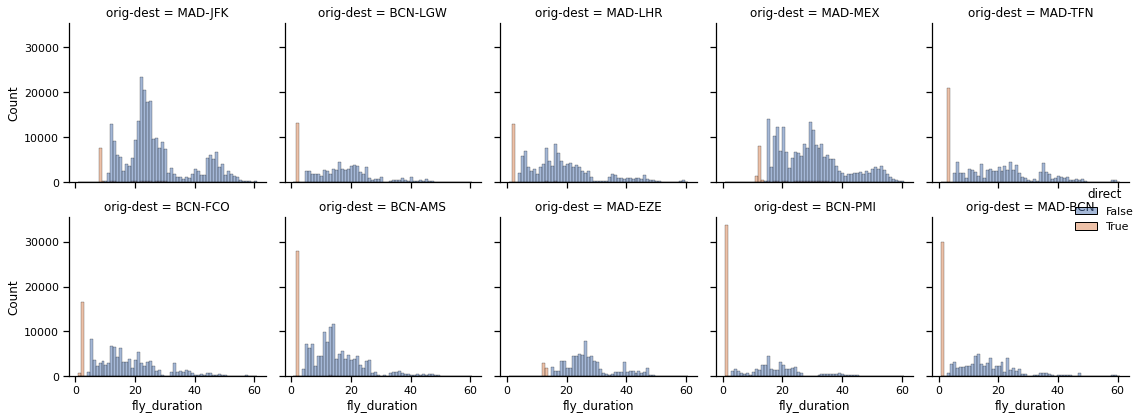

In [56]:
# Price distribution for route
g = sns.displot(
    flights[~broken], x="fly_duration", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3, hue='direct', facet_kws={"legend_out": True}
);
plt.tight_layout()

* Now we can clearly distinguish between direct flights and flights with hopping in the fly_duration distributions now

### Distance

In [57]:
flights['distance'].unique()

array([ 5767.2 ,  1110.28,  1245.76,  9075.77,  1774.11,   847.82,
        1242.46, 10097.94,   202.18,   483.25])

* Distance is fixed for each route. It is the geographical distance between the two airports.

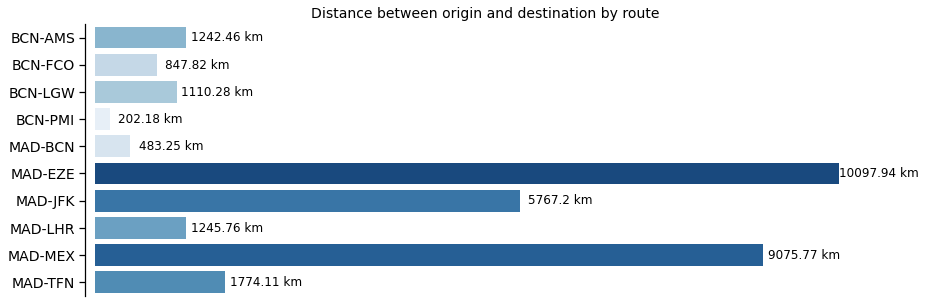

In [58]:
route_distances = flights.groupby('orig-dest')['distance'].mean().reset_index()
pal = sns.color_palette("Blues_r", len(route_distances))
rank = route_distances["distance"].argsort().argsort() 

plt.figure(figsize=(14,5))
g = sns.barplot(y='orig-dest', x='distance', data=route_distances, palette=np.array(pal[::-1])[rank]);

# values text
for index, row in route_distances.iterrows():
    g.text(row['distance']+550, index+0.13, str(round(row['distance'],2))+' km' , color='black', ha="center")

plt.title('Distance between origin and destination by route', fontsize=14)
sns.despine(offset=10, bottom=True)

# remove x axis
plt.xticks([])
plt.xlabel(None)
plt.ylabel(None)

# scale y ticks
plt.yticks(fontsize=14);

### Route

In [59]:
flights['route']

2094685    MAD->TLV->VCE->ZRH->JFK
2780436                   BCN->LGW
2133352              MAD->CDG->LHR
446860                  BCN -> LGW
30235                   MAD -> MEX
                    ...           
603352                  MAD -> JFK
2247187                   BCN->AMS
981084                  BCN -> PMI
1233164         MAD->LIS->GRU->EZE
1610274         BCN->FRA->RIX->LGW
Name: route, Length: 2000000, dtype: object

* This variable shows the hops in a flight route between origin and destination
* We can use this to create a new columns that computes the number of hops

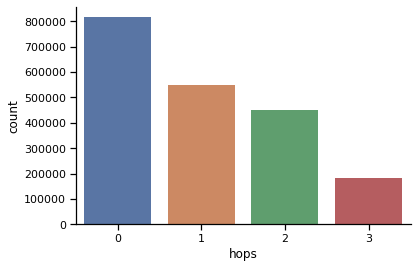

In [62]:
sns.countplot(flights['hops']);
sns.despine(trim=False, offset=0)

Most of the flights are direct. Are direct flights cheaper?

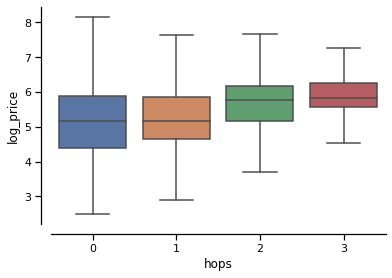

In [92]:
sns.boxplot(x='hops', y='log_price', data=flights, showfliers=False);
sns.despine(offset=10)

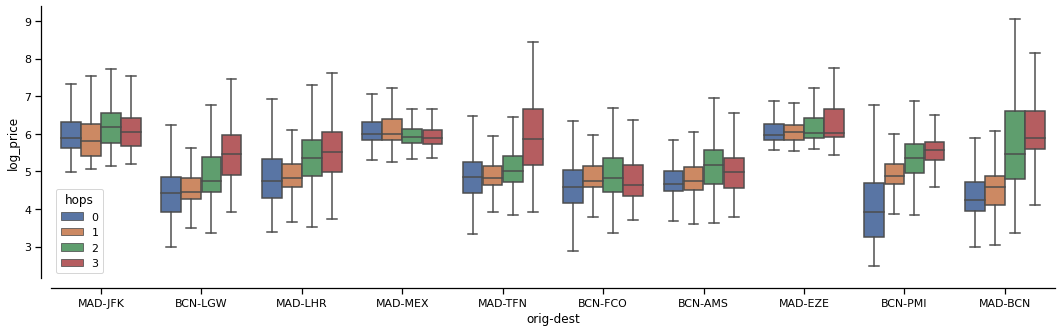

In [94]:
plt.figure(figsize=(18,5))
sns.boxplot(x='orig-dest', y='log_price', data=flights, hue='hops', showfliers=False);
sns.despine(offset=10)

* It seems that it is. In general, direct flights are the cheapest.
* The difference between direct and non-direct is greater in short-distance route as 'BCN-PMI' or 'MAD-BCN'
* In long distance routes this difference is smaller. Even in one route ('MAD-MEX') direct flights are a bit expensive than flights with 2 or more stops.

### Seats

Available seats in the flight? It is not clear what means this variable. Moreover, it has many drop values so it is a great candidate to drop it.

In [95]:
flights['seats'].isna().sum()

427705

In [96]:
flights['seats'].isna().sum() / flights.shape[0]

0.2138525

* This column has many NaN values (21.19%)

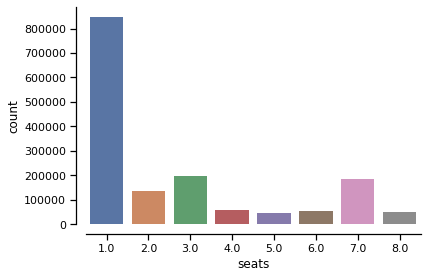

In [100]:
sns.countplot(flights['seats']);
sns.despine(offset=10)

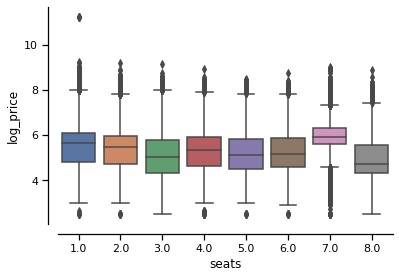

In [99]:
sns.boxplot(x='seats', y='log_price', data=flights);
sns.despine(offset=10)

* There does not appear to be any correlation between seats and price. Except for value 7 which seems to have a slightly higher price.

## Price changes over time

Now that we have taken a look at each of the relevant features of the dataset, let's focus on the main objective of this project. Let's see how the price evolves over time until the day of departure of the flight.
\
We use the first quantile when aggregating data, since we are more interested in low flights fares.

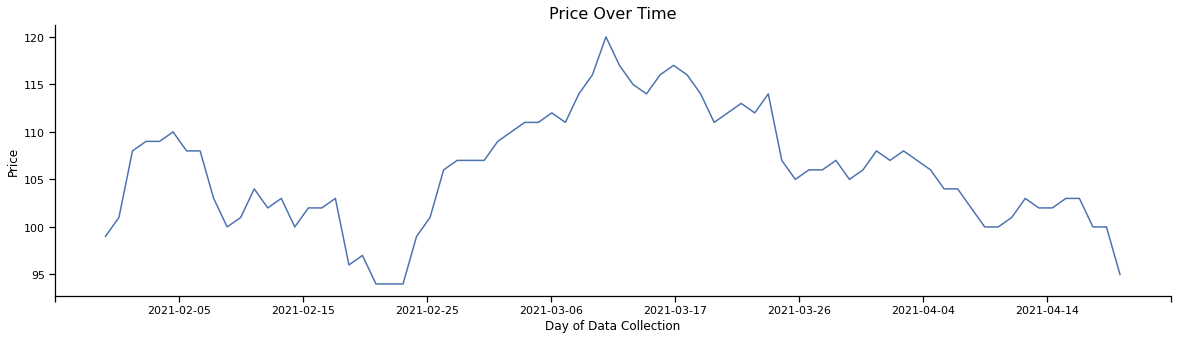

In [160]:
grouped = flights.groupby('collectionDate')['price'].quantile(.25).reset_index()

plt.figure(figsize=(20,5))
f = sns.lineplot(x='collectionDate', y='price', data=grouped);
f.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=0);
sns.despine(offset=0)
plt.xlabel('Day of Data Collection');
plt.ylabel('Price')
plt.title('Price Over Time', fontsize=16);

* As the graph shows, prices rise throughout the month of March and are higher than during April or February. 
* Price decreases seems occur at the end of the month. As we do not have more data we cannot conclude if this is a one-off (COVID third wave in March) or happens more often throughout the year.

Now let's see how price evolves by route:

<Figure size 1008x576 with 0 Axes>

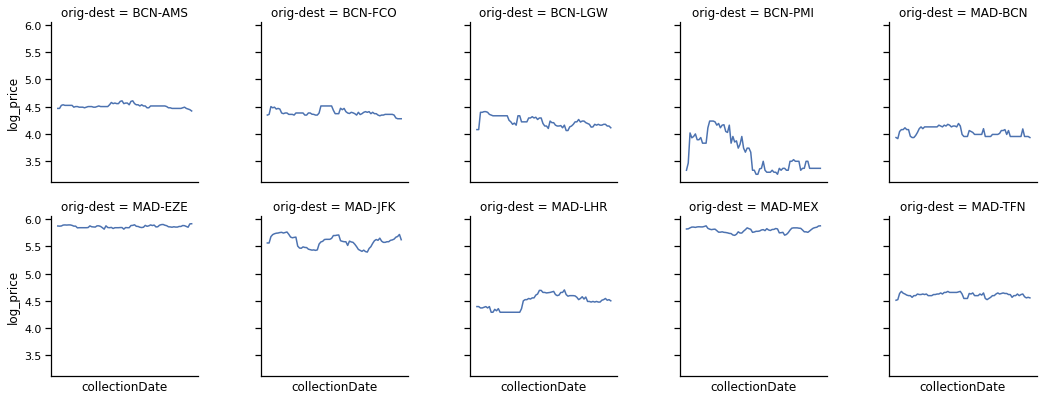

In [149]:
grouped = flights.groupby(['orig-dest','collectionDate'])['log_price'].quantile(.25).reset_index()

plt.figure(figsize=(14,8));
g = sns.FacetGrid(grouped, col="orig-dest", col_wrap=5);
g.map(sns.lineplot, "collectionDate", "log_price");
plt.xticks([]);

* There are quite a few routes where the price does not vary so much.
* The price drop does not occur in all the routes.
* Route MAD-JFK appears to have some degree of seasonality. We cannot confirm this with so little data
* Route BCN-PMI has a steep drop in price during March.

We can't use 'collectionDate' as a feature since we want to make prediction with new days. So let's create a new numeric variable called 'days_until_dep' to group the flights according to how many days left before the departure of the flight. This way we can see how the price changes with time.

In [150]:
def add_days_until_dep_feature(df):
    """ Remaining days until flight departure """
    collected = pd.to_datetime(df['collectionDate'])
    departure =  pd.to_datetime(df['dDate'])
    daysUntilDep = departure - collected
    df['days_until_dep'] = daysUntilDep.apply(lambda x: str(x).split()[0]).astype(int)
    return df

In [151]:
flights = add_days_until_dep_feature(flights)

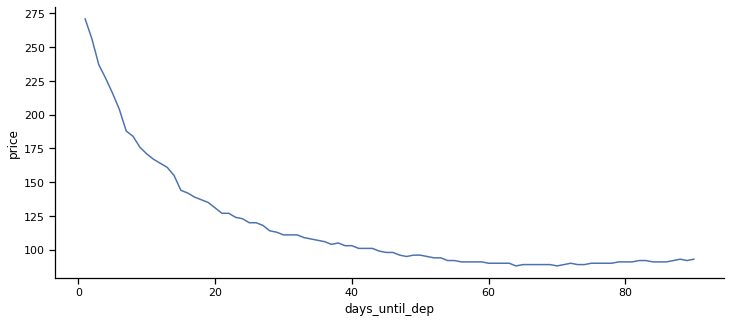

In [158]:
grouped = flights.groupby('days_until_dep')['price'].quantile(.25).reset_index()

plt.figure(figsize=(12,5))

sns.lineplot(x='days_until_dep', y='price', data=grouped);
sns.despine(offset=0);
plt.ylabel('Price')
plt.xlabel('Days unti')

We can use 'collectionDate' column to compute days until the flight departure. This would be a new numerical variable.

In [47]:
collected = pd.to_datetime(flights['collectionDate'])
departure =  pd.to_datetime(flights['dDate'])

daysUntilDep = departure - collected
daysUntilDep = daysUntilDep.apply(lambda x: str(x).split()[0])

In [48]:
flights['daysUntilDep'] = daysUntilDep.astype(int)

In [49]:
collected = pd.to_datetime(pf['collectionDate'])
departure =  pd.to_datetime(pf['dDate'])

daysUntilDep = departure - collected
daysUntilDep = daysUntilDep.apply(lambda x: str(x).split()[0])
pf['daysUntilDep'] = daysUntilDep.astype(int)

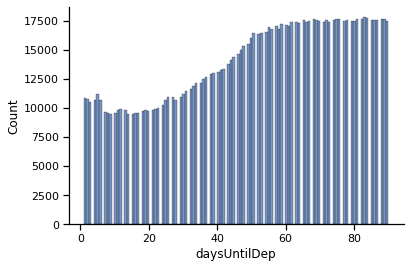

In [50]:
sns.histplot(flights['daysUntilDep']);
sns.despine()

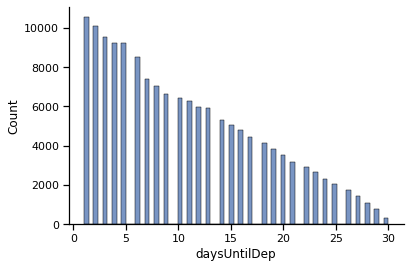

In [51]:
sns.histplot(pf['daysUntilDep']);
sns.despine()

## Multivariate Analysis

In [52]:
corr_mat = flights.corr()
corr_mat['log_price'].sort_values(ascending=False)

log_price       1.000000
price           0.711591
distance        0.663052
fly_duration    0.442167
hops            0.099310
direct         -0.048534
seats          -0.073404
daysUntilDep   -0.097243
Name: log_price, dtype: float64

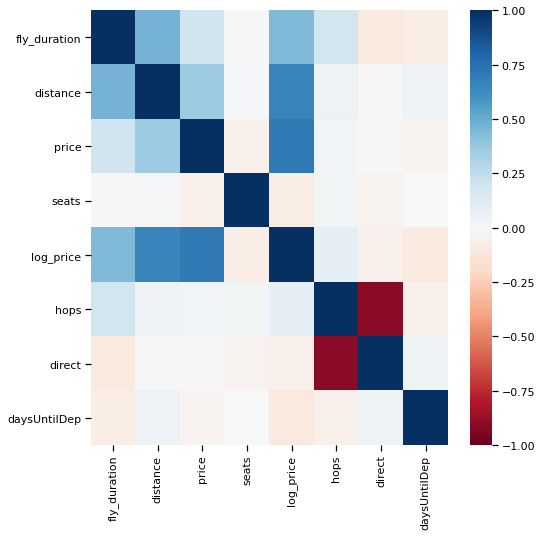

In [53]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, vmin=-1, vmax=1, cmap='RdBu', annot=False);

In [54]:
corr_mat = pf.corr()
corr_mat['log_price'].sort_values(ascending=False)

log_price       1.000000
price           0.789187
distance        0.556749
fly_duration    0.413789
seats           0.105793
daysUntilDep   -0.296162
Name: log_price, dtype: float64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'fly_duration'),
  Text(0, 1.5, 'distance'),
  Text(0, 2.5, 'price'),
  Text(0, 3.5, 'seats'),
  Text(0, 4.5, 'log_price'),
  Text(0, 5.5, 'daysUntilDep')])

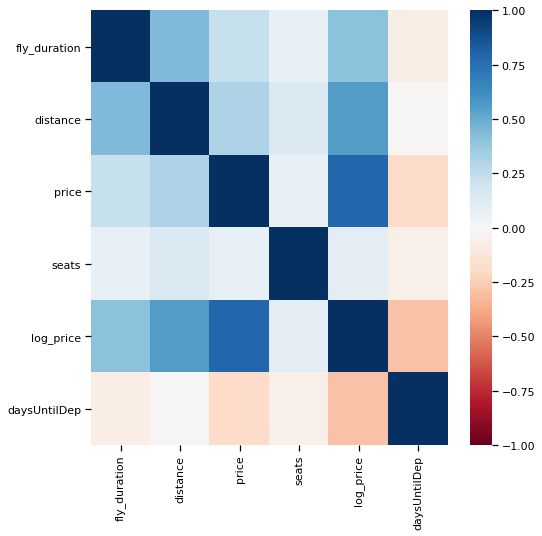

In [55]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, vmin=-1, vmax=1, cmap='RdBu', annot=False);
plt.yticks(rotation=0)

### Price-CollectionDate

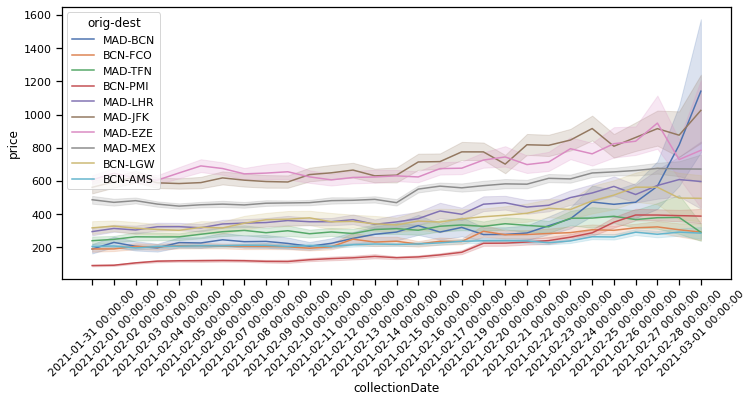

In [56]:
plt.subplots(figsize=(12,5))
sns.lineplot(x='collectionDate', y='price', data=pf, hue='orig-dest');
plt.xticks(rotation=45);

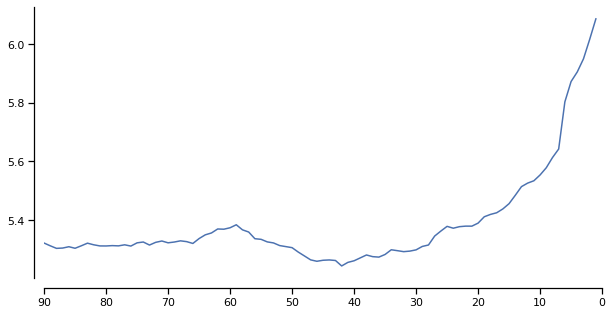

In [57]:
# mean price by remaining days to departure
grouped= flights.groupby('daysUntilDep')['log_price'].mean()
plt.figure(figsize=(10,5))
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);
sns.despine(offset=10)


* The mean price start to decrease around two month before flight departure, reach its minimum at one month, and start increasing two/three weeks before departure.

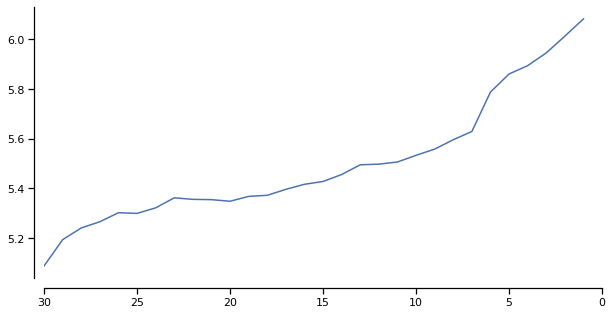

In [58]:
grouped= pf.groupby('daysUntilDep')['log_price'].mean()
plt.figure(figsize=(10,5))
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);
sns.despine(offset=10)

TypeError: unhashable type: 'numpy.ndarray'

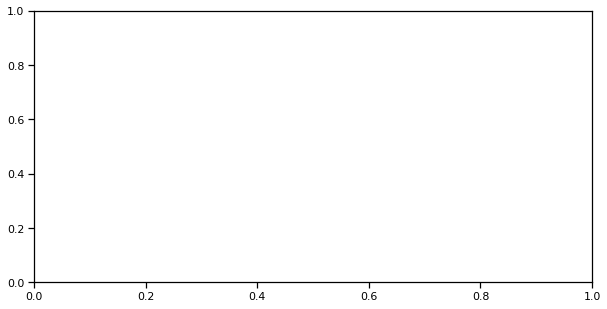

In [59]:
grouped = flights.groupby(['collectionDate','orig-dest','dDate', 'dTime', 'aTime', 'flight_no'])[['log_price']].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);
sns.despine(offset=10)

In [ ]:
# mean price by remaining days to departure
flights[]
flights['hoursUntilDep'] = flights['daysUntilDep']

grouped= flights.groupby('hoursUntilDep')['log_price'].mean()
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);

In [ ]:
flights['flight_no'].head()

In [ ]:
flights_sample = subset_flights(flights, flight_no='UX7703')
grouped= flights_sample.groupby('daysUntilDep')['price'].mean()
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);

## Price-Distance

In [ ]:
sns.scatterplot(x='distance', y='log_price', data=flights);

In [ ]:
grouped = flights.groupby(['dDate', 'dTime'])[['distance','log_price']].mean()
sns.scatterplot(x='distance', y='log_price', data=grouped, alpha=0.9);

* Here we can see how price increases by distance.

## Price-Airlines

In [ ]:
competition = pf.groupby(['flyFrom','flyTo','dDate'])['airline'].nunique().reset_index()
competition.columns = ['flyFrom','flyTo','dDate', 'competition'] 

In [ ]:
merged = pd.merge(pf, competition, on=['dDate', 'flyFrom', 'flyTo'])

In [ ]:
sns.histplot(merged['competition'], bins=50);

In [ ]:
# Fly duration distribution for route
sns.displot(
    merged, x="competition", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3
);
plt.tight_layout()

In [ ]:
grouped = merged.groupby(['flyFrom', 'flyTo','dDate', 'dTime', 'aTime', 'airline'])[['competition', 'log_price']].mean().reset_index()

## Price-Seats

## Exploring dataset with new features from Data Preprocessing Notebook

In [78]:
df = pd.read_csv('../data/processed/train_processed.csv')

In [79]:
df.head()

,id,flyFrom,flyTo,orig-dest,dDate,day_of_month,day_of_week,fly_duration,distance,days_until_dep,session,airline,hops,direct,competition,price,log_price,hist_prices,waiting_days,buy
0,134,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,1.416667,483.25,1,morning,UX,0,True,6,78,4.356709,"[78.0, nan, nan, nan, nan, nan, nan, nan, nan,...",0,0
1,124,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,1.250000,483.25,1,morning,VY,0,True,6,91,4.510860,"[91.0, nan, nan, nan, nan, nan, nan, nan, nan,...",0,0
2,139,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,1.333333,483.25,1,evening,IB,0,True,6,91,4.510860,"[91.0, nan, nan, nan, nan, nan, nan, nan, nan,...",0,0
3,137,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,13.583333,483.25,1,evening,UX,0,True,6,108,4.682131,"[108.0, nan, nan, nan, nan, nan, nan, nan, nan...",0,0
4,132,MAD,BCN,MAD-BCN,2021-02-01,1,Monday,18.000000,483.25,1,morning,UX,0,True,6,112,4.718499,"[112.0, nan, nan, nan, nan, nan, nan, nan, nan...",0,0


In [6]:
df.shape

(115484, 19)

In [7]:
df.columns

Index(['flyFrom', 'flyTo', 'orig-dest', 'dDate', 'day_of_month', 'day_of_week',
       'fly_duration', 'distance', 'days_until_dep', 'session', 'airline',
       'hops', 'direct', 'competition', 'price', 'log_price', 'hist_prices',
       'waiting_days', 'buy'],
      dtype='object')

In [9]:
grouped = df.groupby(['orig-dest', 'airline'])

In [21]:
price_by_airline = grouped['price'].agg(['mean', 'median']).sort_values(by='median').reset_index()

In [22]:
price_by_airline[price_by_airline['orig-dest'] == 'MAD-BCN']

,orig-dest,airline,mean,median
5,MAD-BCN,I2,108.000000,91.0
8,MAD-BCN,UX,127.919814,103.0
12,MAD-BCN,IB,171.166608,120.0
13,MAD-BCN,FR,231.448468,122.0
23,MAD-BCN,VY,182.704518,149.0
27,MAD-BCN,RO,158.500000,158.5
31,MAD-BCN,LX,637.833333,171.5
32,MAD-BCN,W6,227.600000,172.0
33,MAD-BCN,3O,209.228571,173.0
40,MAD-BCN,TP,224.338542,185.0


In [ ]:
grouped = df.groupby(['orig-dest', 'airline', 'session'])
prices = grouped['waiting_days'].agg(['count','mean', 'median']).reset_index()
prices[prices['orig-dest'] == 'MAD-BCN']

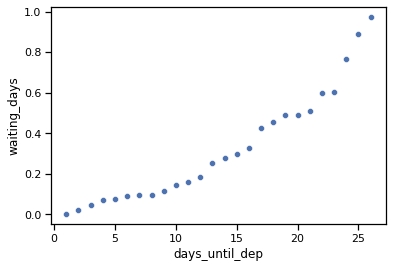

In [53]:
grouped = df.groupby(['days_until_dep'])['waiting_days'].mean().reset_index()
sns.scatterplot('days_until_dep', 'waiting_days', data=grouped);

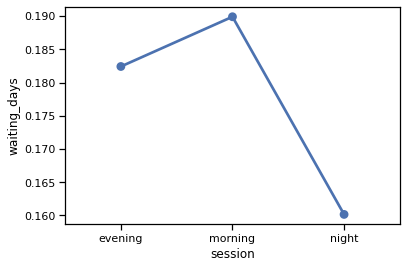

In [62]:
grouped = df.groupby(['session'])['waiting_days'].mean().reset_index()
sns.pointplot('session', 'waiting_days', data=grouped);

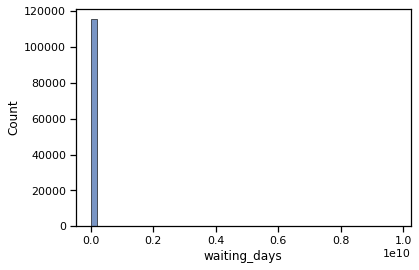

In [69]:
sns.histplot(np.exp(df['waiting_days']), bins=50);

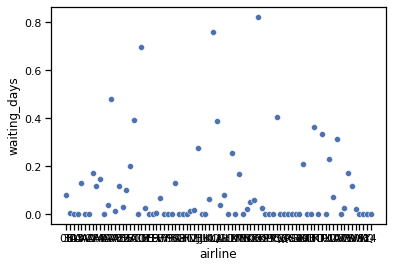

In [64]:
grouped = df.groupby(['airline'])['waiting_days'].mean().reset_index()
sns.scatterplot('airline', 'waiting_days', data=grouped);

In [81]:
df['mean_price'] = df.groupby('id')['price'].transform('min')
df['median_price'] = df.groupby('id')['price'].transform('median')
df['diff_price'] = df['price'] - df['median_price']

In [88]:
df.groupby('id')['price'].count()

id
0        1
1        1
2        1
3        1
4        1
        ..
28940    1
28941    1
28942    3
28943    5
28944    4
Name: price, Length: 28945, dtype: int64

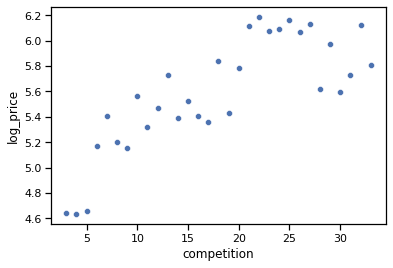

In [97]:
grouped= df.groupby('competition')['log_price'].mean().reset_index()
sns.scatterplot(x='competition', y='log_price', data=grouped);

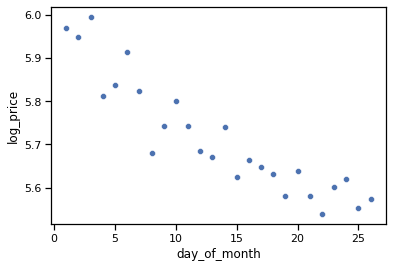

In [99]:
grouped= df.groupby('day_of_month')['log_price'].mean().reset_index()
sns.scatterplot(x='day_of_month', y='log_price', data=grouped);

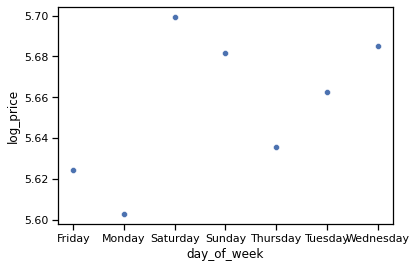

In [102]:
grouped= df.groupby('day_of_week')['log_price'].mean().reset_index()
sns.scatterplot(x='day_of_week', y='log_price', data=grouped);

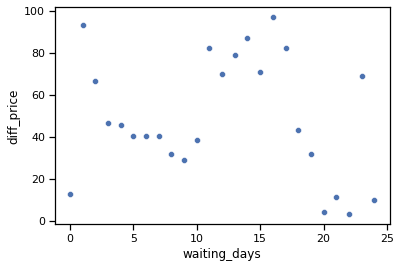

In [104]:
grouped= df.groupby('waiting_days')['diff_price'].mean().reset_index()
sns.scatterplot(x='waiting_days', y='diff_price', data=grouped);

In [106]:
corr_mat = df.corr()
corr_mat['waiting_days'].sort_values(ascending=False)

waiting_days      1.000000
buy               0.758443
days_until_dep    0.227134
day_of_month      0.111931
id                0.108266
diff_price        0.048699
direct            0.013055
price            -0.006705
hops             -0.012024
median_price     -0.025624
mean_price       -0.041483
log_price        -0.051823
distance         -0.054915
competition      -0.062073
fly_duration     -0.097169
Name: waiting_days, dtype: float64